<a href="https://colab.research.google.com/github/shehzanmaredia/speeddetection/blob/master/SpeedDetections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing access to drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
#importing folder
os.chdir('/content/drive/My Drive/Speed Detection')
!ls

In [ ]:
import numpy as np
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
from tqdm import tqdm

import pandas as pd
from sklearn.model_selection import train_test_split

import h5py

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda
from tensorflow.keras.layers import ELU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



In [ ]:
!pip install tensorflow

In [ ]:
!pip install --upgrade tensorflow

In [ ]:
print("num gpu:", len(tf.config.experimental.list_physical_devices('GPU')))

num gpu: 1


In [ ]:
seeds = [1, 2]

In [ ]:
train_meta = pd.read_csv("train.csv")

In [ ]:
train_meta.loc[0, :]

index     0.000000
speed    28.105569
Name: 0, dtype: float64

In [ ]:
def train_validation_split(df_len, seed):
    # train_split = pd.DataFrame()
    # valid_split = pd.DataFrame()

    train_split = []
    valid_split = []

    np.random.seed(seed)

    for i in tqdm(range(df_len - 1)):
        
        if np.random.uniform(0, 1) > 0.2:
            train_split.append(i)
        else:
            valid_split.append(i)
        
    return train_split, valid_split



In [ ]:
train_split, valid_split = train_validation_split(len(train_meta), seeds[0])

100%|██████████| 20399/20399 [00:00<00:00, 237607.49it/s]


In [ ]:
img0 = cv2.imread("clean_test_frames/F0.jpeg", 1)
img1 = cv2.imread("clean_test_frames/F1.jpeg", 1)

In [ ]:
def opticalFlow(frame1, frame2):
    prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    hsv = np.zeros_like(frame1)
    hsv[..., 1] = 255
    next = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    # try to understand optical flow and these parameters
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    flow = cv2.calcOpticalFlowFarneback(prvs,
                                        next,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)
    
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return bgr

In [ ]:
out = opticalFlow(img0, img1)

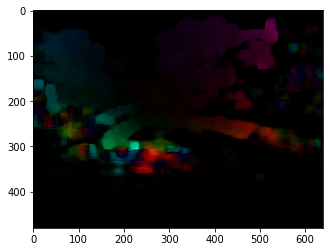

In [ ]:
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))

In [ ]:
def horizontal_flip(image): 
    return np.fliplr(image)

def adjust_saturation(image, saturation_factor):    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    hsv_image[:,:,1] = hsv_image[:,:,1] * saturation_factor
    
    image_bgr = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
    return image_bgr

In [ ]:
def blur_image(image):
    return cv2.GaussianBlur(image, (5,5), 0)

def edge_detection(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGR2GRAY)
    return cv2.Canny(gray, 100, 200)

def adjust_brightness(image, bright_factor):
    # np.random.seed(seeds[1])
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
    return image_rgb

    return image

def preprocess_image(image):
    image_cropped = image[100:440, :]
    
    image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    
    return image

def preprocess_image_from_path(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_image(img)
    return img

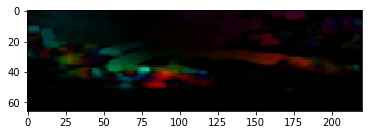

In [ ]:
out2 = preprocess_image(out)
plt.imshow(cv2.cvtColor(out2, cv2.COLOR_BGR2RGB))

In [ ]:
def generate_training_data(train_split, train_meta, batch_size = 30):
    image_batch = np.zeros((batch_size, 66, 220, 3))
    label_batch = np.zeros((batch_size))

    while True:
        for i in range(batch_size):

            idx = np.random.randint(0, len(train_split))

            index1 = train_split[idx]
            index2 = index1 + 1

            # this is where preprocessing features can be added

            
            img1 = preprocess_image_from_path(f"clean_train_frames/F{index1}.jpeg")
            img2 = preprocess_image_from_path(f"clean_train_frames/F{index2}.jpeg")

            bright_factor = 0.2 * np.random.uniform()

            img1 = blur_image(adjust_brightness(img1, bright_factor))
            img2 = blur_image(adjust_brightness(img2, bright_factor))

            if np.random.uniform() < 0.5:
                img1 = horizontal_flip(img1)
                img2 = horizontal_flip(img2)

            flow = opticalFlow(img1, img2)

            image_batch[i] = flow
            label_batch[i] = (train_meta.iloc[index1]["speed"] + train_meta.iloc[index2]["speed"]) / 2

        yield image_batch, label_batch

def generate_validation_data(valid_split, train_meta):
    while True:
        for idx in range(0, len(valid_split)):
            index1 = train_split[idx]
            index2 = index1 + 1

            img1 = preprocess_image_from_path(f"clean_train_frames/F{index1}.jpeg")
            img2 = preprocess_image_from_path(f"clean_train_frames/F{index2}.jpeg")

            flow = opticalFlow(img1, img2)
            flow = flow.reshape(1, *np.shape(flow))

            speed = (train_meta.iloc[index1]["speed"] + train_meta.iloc[index2]["speed"]) / 2

            speed = np.array([[speed]])

            # yield img1.reshape(1, *np.shape(flow)), speed   # this was original line. makes zero sense.
            yield flow, speed

In [ ]:
N_img_height = 66
N_img_width = 220
N_img_channels = 3

def vg177_insane_triple_max():
    inputShape = (N_img_height, N_img_width, N_img_channels)

    model = Sequential()
    # normalization    
    # perform custom normalization before lambda layer in network
    model.add(Lambda(lambda x: x/ 127.5 - 1, input_shape = inputShape))

    model.add(Convolution2D(24, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv1'))
    
    
    model.add(ELU())    
    model.add(Convolution2D(36, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv2'))
    
    model.add(ELU())    
    model.add(Convolution2D(48, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv3'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, (3, 3), 
                            strides = (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv4'))
    
    model.add(ELU())              
    model.add(Convolution2D(64, (3, 3), 
                            strides= (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv5'))
              
              
    model.add(Flatten(name = 'flatten'))
    model.add(ELU())
    model.add(Dense(100, kernel_initializer = 'he_normal', name = 'fc1'))
    model.add(ELU())
    model.add(Dense(50, kernel_initializer = 'he_normal', name = 'fc2'))
    model.add(ELU())
    model.add(Dense(10, kernel_initializer = 'he_normal', name = 'fc3'))
    model.add(ELU())
    
    # do not put activation at the end because we want to exact output, not a class identifier
    model.add(Dense(1, name = 'output', kernel_initializer = 'he_normal'))
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = adam, loss = 'mse')

    return model

In [ ]:
def generate_input_data(train_meta):
    DATASET_SIZE = len(train_meta)

    images = np.zeros((DATASET_SIZE, 66, 220, 3))
    labels = np.zeros(DATASET_SIZE)

    for i in tqdm(range(DATASET_SIZE - 1)):
        img1 = preprocess_image_from_path(f"clean_train_frames/F{i}.jpeg")
        img2 = preprocess_image_from_path(f"clean_train_frames/F{i + 1}.jpeg")

        bright_factor = 0.2 * np.random.uniform()

        img1 = blur_image(adjust_brightness(img1, bright_factor))
        img2 = blur_image(adjust_brightness(img2, bright_factor))

        flow = opticalFlow(img1, img2)

        speed = (train_meta.iloc[i]["speed"] + train_meta.iloc[i + 1]["speed"]) / 2

        images[i] = flow
        labels[i] = speed

    return images, labels





In [ ]:
val_size = len(valid_split)
valid_generator = generate_validation_data(valid_split, train_meta)
BATCH = 10
print('val_size: ', val_size)

filepath = 'asdf.h5'
earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=1, 
                              verbose=1, 
                              min_delta = 0.23,
                              mode='min',)
modelCheckpoint = ModelCheckpoint(filepath, 
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                 save_weights_only = True)
callbacks_list = [modelCheckpoint]

model = vg177_insane_triple_max()
train_size = len(train_split)
train_generator = generate_training_data(train_split, train_meta, BATCH)

history = model.fit_generator(
        generator = train_generator,
        steps_per_epoch = 400, 
        epochs = 85,
        callbacks = callbacks_list,
        verbose = 1,
        validation_data = valid_generator,
        validation_steps = val_size)

print(history)

'''

x, y = generate_input_data(train_meta)


history = model.fit(
        x = x,
        y = y,
        batch_size = BATCH,
        epochs = 85,
        callbacks = callbacks_list,
        verbose = 1,
        shuffle = True,
        validation_split = 0.2,
)
'''

In [ ]:
!pip freeze | grep tensorflow

# Inference

In [ ]:
model = vg177_insane_triple_max()
model.load_weights('alan-sat-bright-flip.h5')

In [ ]:
test_meta = pd.read_csv("train.csv")

In [ ]:
preds = []
actuals = []

for idx in range(1000, len(test_meta), 200):
    index1 = idx
    index2 = index1 + 1

    img1 = preprocess_image_from_path(f"clean_train_frames/F{index1}.jpeg")
    img2 = preprocess_image_from_path(f"clean_train_frames/F{index2}.jpeg")

    flow = opticalFlow(img1, img2)
    flow = flow.reshape(1, *np.shape(flow))

    actual = (test_meta.iloc[index1]["speed"] + test_meta.iloc[index2]["speed"]) / 2

    pred = model.predict(flow, batch_size=1)
    print('Predicted: {}\t\tActual: {}'.format(pred[0][0], actual))
    
    preds.append(pred[0][0])
    actuals.append(actual)


In [ ]:
plt.figure(figsize=(16,8))
plt.plot(preds, marker='o', markerfacecolor='blue')
plt.plot(actuals, marker='x', color='olive', linewidth=2)
plt.show()

In [ ]:
preds = []

prev = preprocess_image_from_path(f"clean_test_frames/F{0}.jpeg")
for idx in tqdm(range(1, 10798)):
    curr = preprocess_image_from_path(f"clean_test_frames/F{idx}.jpeg")

    flow = opticalFlow(prev, curr)
    flow = flow.reshape(1, *np.shape(flow))

    pred = model.predict(flow, batch_size=1)
    
    preds.append(pred[0][0])
    prev = curr

100%|██████████| 10797/10797 [57:12<00:00,  3.59it/s]


In [ ]:
np.savetxt('test.txt', preds)

In [ ]:
test = np.loadtxt('testa.txt')